<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Modules-Definition" data-toc-modified-id="Modules-Definition-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modules Definition</a></span></li><li><span><a href="#Importing-and-Preprocessing-Documents" data-toc-modified-id="Importing-and-Preprocessing-Documents-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Importing and Preprocessing Documents</a></span></li><li><span><a href="#Creation-of-doc2vec" data-toc-modified-id="Creation-of-doc2vec-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Creation of doc2vec</a></span></li><li><span><a href="#Use-the-doc2vec-model" data-toc-modified-id="Use-the-doc2vec-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Use the <code>doc2vec</code> model</a></span></li><li><span><a href="#Different-Algorithms-for-Cluster-Analysis" data-toc-modified-id="Different-Algorithms-for-Cluster-Analysis-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Different Algorithms for Cluster Analysis</a></span><ul class="toc-item"><li><span><a href="#K-mean-Clustering" data-toc-modified-id="K-mean-Clustering-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>K-mean Clustering</a></span></li><li><span><a href="#DBClustering" data-toc-modified-id="DBClustering-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>DBClustering</a></span></li><li><span><a href="#HDBClustering" data-toc-modified-id="HDBClustering-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>HDBClustering</a></span></li><li><span><a href="#Hierarchical-Clustering" data-toc-modified-id="Hierarchical-Clustering-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Hierarchical Clustering</a></span><ul class="toc-item"><li><span><a href="#Focus-on-the-biggest-cluster" data-toc-modified-id="Focus-on-the-biggest-cluster-6.4.1"><span class="toc-item-num">6.4.1&nbsp;&nbsp;</span>Focus on the biggest cluster</a></span></li><li><span><a href="#Focus-on-excluding-the-biggest-cluster" data-toc-modified-id="Focus-on-excluding-the-biggest-cluster-6.4.2"><span class="toc-item-num">6.4.2&nbsp;&nbsp;</span>Focus on excluding the biggest cluster</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pandas as pd
from gensim.corpora import Dictionary
import numpy as np
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from gensim.models import doc2vec
from collections import namedtuple
import nltk
from nltk.cluster import KMeansClusterer
from sklearn import metrics
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Introduction

In this notebook, we tested different clustering algorithms, both using hierarchical approaches as well as k-means based approaches. After testing and manual verification, we decided to keep a k-mean clustering solution with 7 clusters. This solution is able to properly assign 3503 users (out of a total of 7621 observations.) The preprocessing phase eliminates 4118 observations (for different reasons.)

Eventually, we decided to assign all users to a cluster. More specifically, we use the following coding system:
- -11: cluster identifying users with empty description field (804 users)
- -10: cluster identifying users with a value different from "it" in the language field (2004 users)
-  -9: cluster identifying users filtered via preprocessing (italian vocabulary and stopwords, etc.
 -- 1310 users)

All the other users are assigned to clusters from 0 to 6, using a k-means algorithm.

# Modules Definition

- `preProcess()`: Text preprocessing, to tokenize, remove stopwords, and sentences that are too short.
- `addTags()`: This is needed to change the structure of each sentence (tweet) in the format required by doc2vec. We need to add a tag to each document.
- `nltkClustering()`: Run the k-mean clustering algorithm implemented in the NLTK library.

In [4]:
def preProcess(df):
    """
    Preprocess documents and save them in three data structures (a bit inefficient...):
    - docs, corpus, idOriginal: These contain the documents used in the doc2vec module below 
      (the users surviving the preprocessing phase)
    - docsElim etc. : Users eliminated because the description field, after preprocessin, has
      a lenght of less than or equal to 2 words
    - idOriginalEmpty: We store here the id of users whose "Description" field is empty
    """
    docs = []
    corpus = []
    idOriginal = []
    
    docsElim = []
    corpusElim = []
    idOriginalElim = []

    idOriginalEmpty = []

    countWords = 0
    countDict = 0
    countShort = 0
    i = 0
    for ss in df["Description"]:
        i += 1
        #print(df.iloc[i-1])
        if (i % 1000 == 0):
            print("Doc {0:5d} has been processed".format(i))
        if pd.isnull(ss):
            #print("We skip this ", ss)
            idOriginalEmpty.append(df.iloc[i-1][0])
            continue


        tokens = word_tokenize(ss)
        #print(tokens)
        countWords += len(tokens)
        for w in tokens:
            #print("w ", w, " in dictionary? ", w in dct.token2id)
            if w not in dct.token2id:
                countDict += 1
        words = [w.lower() for w in word_tokenize(ss) if w not in stop_words and w in dct.token2id]
        #print("*** WORDS = ", words)
        if len(words) > 2:
            docs.append(words)
            corpus.append(ss)
            idOriginal.append(df.iloc[i-1][0])
            #print("*** ID = ", df.iloc[i-1][0])
        else:
            docsElim.append(words)
            corpusElim.append(ss)
            idOriginalElim.append(df.iloc[i-1][0])
            
            countShort += 1
    print("Dict = ", countDict, " (", countWords, " - ", countDict/countWords, " ) and Short = ", countShort)
    
    return docs, corpus, idOriginal, docsElim, corpusElim, idOriginalElim, idOriginalEmpty

def addTags(docs):
    """
    Modification needed to use doc2vec. Each document receives a tag (a unique id)
    """
    dTags = []
    analyzedDocument = namedtuple("AnalyzedDocument", "words tags")
    for i, doc in enumerate(docs):
        tags = [i]
        dTags.append(analyzedDocument(doc, tags))
    return dTags

In [5]:
def nltkClustering(vectors, nrClusters, repeats):
    """
    Use the clustering function of NLTK. The algorithm is applied on the set of vectors contained in the 
    datastructure `vectors`.
    """

    num_clusters = nrClusters
    kclusterer = KMeansClusterer(num_clusters, 
        distance = nltk.cluster.util.cosine_distance,
        #  distance = nltk.cluster.util.euclidean_distance,
        repeats = repeats)
    labels = kclusterer.cluster(vectors, assign_clusters=True)
    score = metrics.silhouette_score(vectors, labels, metric="cosine")
    print("Silhouette score (nc = ", nrClusters, " ) = ", score )

    return labels, score

# Importing and Preprocessing Documents 

In [6]:
#dfUsers = pd.read_csv("data/user_descriptions.csv")
dfUsers = pd.read_csv("data/users_bank_10_2018.csv")
print("Total Number of Users in the dataset = ", len(dfUsers))
print(dfUsers.head())

Total Number of Users in the dataset =  7621
   REF    USER_ID          NAME_ID  \
0    1  307856934  prof_mrodrigues   
1    2  200802917        Ggferrara   
2    3  104558819       vivsmith71   
3    4  283932101          orsomik   
4    5  252531934     moneyfarmITA   

                                         Description LANG  \
0                Assessor Administrativo e Professor   pt   
1  Jack of all trades, master of none | [SARCASM ...   it   
2  Trainee clinical psychologist @uclpals & part ...   en   
3  Professional Trainer,  Business & Life Coach, ...   it   
4  Miglior Consulente Finanziario Indipendente 2018.   it   

                      NAME  FOLLOWERS  FOLLOWED  TWEETS  \
0         Márcio Rodrigues         79       189     360   
1            Luigi Ferrara       1606      1299   20207   
2                Viv Smith        814       905    6258   
3  Michele Orsenigo #34361       1460      1911   54538   
4         Moneyfarm Italia      17082     11014   57030   

    

We select here only users with Language = "it", i.e., users which labels themselves as using the Italian language. It is not a great approach, since the description field still contains a large number of non-italian words (even when the user identifies himself as "it".) The problem is that, often, the language used in the description field is mixed (part italian part english...)

In [7]:
dfNoIt = dfUsers[dfUsers["LANG"] != "it"]
dfUsers = dfUsers[dfUsers["LANG"]=="it"]
dfNoIt.to_csv("data/clustersNoIt.csv")

In [8]:
print("Number of Not It =", len(dfNoIt), " vs IT = ", len(dfUsers))
print("We thus retain ", len(dfUsers), "users.\n")
print(dfNoIt.head())

Number of Not It = 2004  vs IT =  5617
We thus retain  5617 users.

   REF    USER_ID          NAME_ID  \
0    1  307856934  prof_mrodrigues   
2    3  104558819       vivsmith71   
6    7   52350953          adpucci   
7    8   92785595   semaphore_info   
8    9  147901692        Youstitia   

                                         Description LANG               NAME  \
0                Assessor Administrativo e Professor   pt   Márcio Rodrigues   
2  Trainee clinical psychologist @uclpals & part ...   en          Viv Smith   
6  Woman. Libertine.  Picker, grinner, lover, sin...   en          Pucci D 🔥   
7  Spécialiste indépendant #veille #conseil #étud...   fr  Sémaphore Conseil   
8  La Giustizia è una cosa seria, anche Tu lo sei...   en          YouStitia   

   FOLLOWERS  FOLLOWED  TWEETS                      LOCATION     JOIN_DATE  \
0         79       189     360                 Votorantim/SP  40693.512662   
2        814       905    6258                    London, UK  4019

Now, upload dictionary and stopwords, and eleminate users if length of final description is not above 2. The dictionary has been built starting from the Italian wikipedia. We cut the length of the dictionary to 1M words.

In [9]:
dct = Dictionary.load_from_text("data/dictWiki.txt")

In [10]:
print("Length dictionary before filter = ", len(dct))
dct.filter_extremes(keep_n=1000000)
print("Length dictionary after filter = ", len(dct))

Length dictionary before filter =  2022361


2018-11-22 09:18:12,345 : INFO : discarding 1307630 tokens: [('al', 670883), ('alla', 533998), ('bagchee', 3), ('categoria', 695352), ('che', 694169), ('collegamenti', 623305), ('con', 695374), ('da', 678541), ('dal', 544442), ('debain', 4)]...
2018-11-22 09:18:12,346 : INFO : keeping 714731 tokens which were in no less than 5 and no more than 524298 (=50.0%) documents
2018-11-22 09:18:14,943 : INFO : resulting dictionary: Dictionary(714731 unique tokens: ['saziati', 'monoceros', 'iuventas', 'usclas', 'medievistica']...)


Length dictionary after filter =  714731


In [11]:
stop_words = stopwords.words("italian") # upload stopwords (NLTK library)

In [12]:
docs, corpus, idOriginal, docsElim, corpusElim, idOriginalElim, idOriginalEmpty = preProcess(dfUsers)
dTags = addTags(docs)
print("Preprocessed and transformed ", len(dTags), " documents.")
# save all users excluded because of dictionary cut or stopwords, etc. Length of user description <= 2
df = pd.DataFrame({
    "id" : idOriginalElim,
    "Description" : corpusElim,
    "Keywords" : docsElim,
    "cluster.7": [-9]*len(idOriginalElim)
})
print("** Retaining ", len(df), " users.")
print("** Eliminating ", len(idOriginalElim)," users due to grammar and length.")
df.to_csv("data/clustersNoDict.csv") # users with short description after preprocessing
df = pd.DataFrame ({
    "id" : idOriginalEmpty,
    "cluster.7": [-11]*len(idOriginalEmpty)
})
print("** Eliminating ", len(idOriginalEmpty)," users due to empty field.")
df.to_csv("data/clustersEmpty.csv") # users with empty description field


Doc  1000 has been processed
Doc  2000 has been processed
Doc  3000 has been processed
Doc  4000 has been processed
Doc  5000 has been processed
Dict =  51761  ( 83077  -  0.6230484971773175  ) and Short =  1314
Preprocessed and transformed  3499  documents.
** Retaining  1314  users.
** Eliminating  1314  users due to grammar and length.
** Eliminating  804  users due to empty field.


# Creation of doc2vec

We create a new doc2vec model, based on user descriptions, rather than "recycling" the doc2vec model we obtained from the tweets. 

In [ ]:
# run this chunk if we need to create the model
model = doc2vec.Doc2Vec(size=300, window=300, min_count=2, iter=1000, workers=4, dm=1, max_vocab_size=50000)
model.build_vocab(dTags)
model.train(dTags, total_examples=model.corpus_count, epochs=model.iter)
model.init_sims(replace=True)

In [ ]:
# save model on disk
model.save("doc2vecUsers.model.dm")

In [ ]:
# upload model from disk if it already exists
model = doc2vec.Doc2Vec.load("doc2vecUsers.model.dm")

Run a little consistency test. Verify whether the models produced by doc2vec is able to properly infer new vectors. More specifically, we apply the following steps:
- take each document and infer the vector using doc2vec (rather than using the vector produced by doc2vec, we infer a new one, as if that document has never been seen before). Let us call this document `doc1` and this inferred vector `v1`
- find the document whose vector representation is the closest one to `v1`. If the doc2vec model is working properly, the document closest to `doc1` in the corpus should be precisely `doc1`. That is, if the inferred vector is meaningful, `v1` should be very close to the vector representation associated to that document in the corpus.

In [ ]:
withTest = 1
if withTest:
    x = []
    for idx in range(500):
        v0 = model.infer_vector(dTags[idx].words, steps=10000)
        sims = model.docvecs.most_similar([v0], topn=len(docs))
        rank = [idx for idx,sim in sims].index(idx)
        x.append(rank)
        if idx % 5 == 0:
            print("Vector ", idx, " has rank ", rank)

# Use the `doc2vec` model

Note that there are two implementations of the doc2vec model:
- doc2vecTwitter.model: This is the model obtained when the option "dm=0" is used in the generation of the model using the gensim module.
- doc2vecTwitter.model.dm: This model is obtained activating "dm=1". Some papers in the literature say that the doc2vec model obtained using "dm=1" is of higher quality than the one obtained with "dm=0".

In [14]:
#model = doc2vec.Doc2Vec.load("doc2vecTwitter.model")
vecs = []
for idx in range(len(docs)):
    if idx % 25 == 0:
        print("Processing document ", idx)
    v0 = model.infer_vector(dTags[idx].words, steps=10000)
    vecs.append(v0)   
print("Done.")

Processing document  0
Processing document  25
Processing document  50
Processing document  75
Processing document  100
Processing document  125
Processing document  150
Processing document  175
Processing document  200
Processing document  225
Processing document  250
Processing document  275
Processing document  300
Processing document  325
Processing document  350
Processing document  375
Processing document  400
Processing document  425
Processing document  450
Processing document  475
Processing document  500
Processing document  525
Processing document  550
Processing document  575
Processing document  600
Processing document  625
Processing document  650
Processing document  675
Processing document  700
Processing document  725
Processing document  750
Processing document  775
Processing document  800
Processing document  825
Processing document  850
Processing document  875
Processing document  900
Processing document  925
Processing document  950
Processing document  975
Proce

We want to get a quick graphical representation of the vector space model produced by `doc2vec`. We use Principal Component Analysis.

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.decomposition import PCA as sklearnPCA

In [16]:
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(vecs))


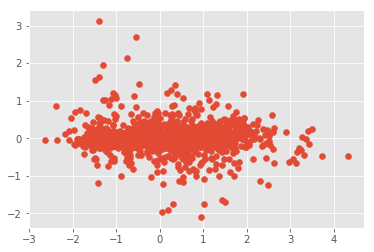

In [17]:
plt.scatter(transformed[0], transformed[1])
plt.show()

As we can see, in reality, is seems that all the vectors belong to a single cluster. The strongest solution is still the one that keeps all the users together...

# Different Algorithms for Cluster Analysis

## K-mean Clustering
We first run the clustering algorithm with multiple values of the $k^*$ value. We then select the most appropriate vaues, based on the _silhouette_ score. Finally, the resulting cluster solution is saved on disk.

In [24]:
print(len(vecs))
for nc in range(3,10):
    label, score = nltkClustering(vecs, nrClusters = nc, repeats=50)

3503
Silhouette score (nc =  3  ) =  0.260172
Silhouette score (nc =  4  ) =  0.174511
Silhouette score (nc =  5  ) =  0.160087
Silhouette score (nc =  6  ) =  0.153601
Silhouette score (nc =  7  ) =  0.18794
Silhouette score (nc =  8  ) =  0.157757
Silhouette score (nc =  9  ) =  0.127336


In [ ]:
for nc in range(10,20):
    label, score = nltkClustering(vecs, nrClusters = nc, repeats=50)

In [26]:
label3, score = nltkClustering(vecs, nrClusters = 3, repeats=50)

Silhouette score (nc =  3  ) =  0.255784


In [27]:
label7, score = nltkClustering(vecs, nrClusters = 7, repeats=50)

Silhouette score (nc =  7  ) =  0.156698


Save the best solution(s), based on the silhouette score.

In [28]:
df = pd.DataFrame({
    "id" : idOriginal,
    "Description" : corpus,
    "Keywords" : docs,
    "cluster.3": label3,
    "cluster.7": label7
})
print(df.head())
df.to_csv("data/clustersNltk.csv")

                                         Description  \
0  Jack of all trades, master of none | [SARCASM ...   
1  Professional Trainer,  Business & Life Coach, ...   
2  Sail fast, Live slow. Father. Geek, DIY evange...   
3  Padre. Money manager. Fu BimboAlieno. Economia...   
4  In @ReteDisarmo cercando nonviolenza. Il megli...   

                                            Keywords  cluster.3  cluster.7  id  
0                     [of, trades, master, of, none]          0          0   2  
1                     [consultant, are, endorsement]          0          1   4  
2  [fast, slow, evangelist, inside, fan, student,...          1          2   6  
3                       [manager, collaboro, gruppo]          0          1  11  
4  [cercando, nonviolenza, meglio, moglie, figlie...          2          6  13  


## DBClustering

The advantage of this method is that it does not force every point of the set to be assigned to a cluster. Some points can be treated as "noise" and are left out from the assignment. This sounds like a good idea, since it might find that only some of the users are grouped together.

There are basically two versions of these types of clustering algorithms:
- non-hierarchical: DBSCAN
- hierarchical : HDBSCAN

Below, I use both of them. As we can see, the results lead to a non-meaningful assigment. Only one cluster is created, regardless of which method and metric are used. 

In [18]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [19]:
#X = StandardScaler().fit_transform(vecs)

algos = ['auto', 'ball_tree', 'kd_tree', 'brute']
all_metrics = ['cosine', 'euclidean', 'correlation', 'matching']

# Compute DBSCAN
for algo in algos:
    for mm in all_metrics:
        X = vecs
        try:
            db = DBSCAN(eps=0.7, min_samples=10, n_jobs=-1, algorithm=algo, metric=mm).fit(X)
        except:
            continue
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        #print(labels)
        try:
            score = metrics.silhouette_score(X, labels, metric=mm)
        except:
            score = 0.0
        print("Algo = {0}\t Metric = {1}\t Nr.Cluster = {2}, Silhouette = {3}".format(algo, mm, n_clusters_, score))

Algo = auto	 Metric = cosine	 Nr.Cluster = 1, Silhouette = 0.021826492622494698
Algo = auto	 Metric = euclidean	 Nr.Cluster = 1, Silhouette = 0.19671845436096191
Algo = auto	 Metric = correlation	 Nr.Cluster = 1, Silhouette = 0.02186415038689617
Algo = auto	 Metric = matching	 Nr.Cluster = 1, Silhouette = 0.0
Algo = ball_tree	 Metric = euclidean	 Nr.Cluster = 1, Silhouette = 0.19671845436096191
Algo = ball_tree	 Metric = matching	 Nr.Cluster = 1, Silhouette = 0.0
Algo = kd_tree	 Metric = euclidean	 Nr.Cluster = 1, Silhouette = 0.19671845436096191
Algo = brute	 Metric = cosine	 Nr.Cluster = 1, Silhouette = 0.021826492622494698
Algo = brute	 Metric = euclidean	 Nr.Cluster = 1, Silhouette = 0.19671845436096191
Algo = brute	 Metric = correlation	 Nr.Cluster = 1, Silhouette = 0.02186415038689617


/home/mcaserta/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype float32 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Algo = brute	 Metric = matching	 Nr.Cluster = 1, Silhouette = 0.0


In [ ]:
X = vecs
db = DBSCAN(eps=0.7, min_samples=10, n_jobs=-1, algorithm='auto', metric='cosine').fit(X)
labels = db.labels_
score = metrics.silhouette_score(X, labels, metric='cosine')
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Nr. Clusters = ", n_clusters_, "Silhouette = ", score)
df = pd.DataFrame({
    "id" : idOriginal,
    "Description" : corpus,
    "Keywords" : docs,
    "labels": labels
})
print(df.head())
df.to_csv("data/clustersDBSCAN.csv")

## HDBClustering

A hierarchical clustering algorithm based on DBClustering.

In [21]:
import hdbscan
from sklearn.datasets import make_blobs


In [22]:
blobs, labels = make_blobs(n_samples=2000, n_features=10)
pd.DataFrame(blobs).head()


,0,1,2,3,4,5,6,7,8,9
0,4.586577,10.121486,7.742454,9.620633,8.271808,0.941111,-3.673836,-3.616351,1.666774,4.139957
1,-4.525988,9.718526,4.583538,-1.250788,4.475234,-0.830563,-1.978461,-4.144216,5.329160,5.437551
2,6.534317,-10.323447,-8.731192,1.488943,-5.454516,1.742315,3.600310,4.270600,2.107223,-8.816209
3,-7.138337,8.980842,4.348521,-1.898735,2.022532,-2.320467,-2.057687,-2.018512,6.996454,5.946531
4,-5.899854,9.198309,6.475198,-3.436227,5.467570,-2.881740,-3.660502,-2.079042,5.314516,6.647001


In [23]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, algorithm='prims_kdtree')
clusterer.fit(blobs)

HDBSCAN(algorithm='prims_kdtree', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=10, min_samples=None, p=None,
    prediction_data=False)

In [24]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [25]:
X = StandardScaler().fit_transform(vecs)

In [26]:
db = DBSCAN(eps=0.3, min_samples=5, n_jobs=-1, algorithm="kd_tree").fit(vecs)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [27]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(labels)
print(n_clusters_)
score = metrics.silhouette_score(vecs, labels, metric="cosine")
print("Silhouette score = ", score )


[-1 -1 -1 ..., -1 -1 -1]
2
Silhouette score =  -0.0501997


## Hierarchical Clustering

In [28]:
import collections
import scipy.spatial.distance as ssd
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet

Vector `vecs` contains the doc2vec representation of each username. We now need to compute a distance matrix and, from there, apply hierarchical clustering. The following is copied from "perDay.ipynb", in subfolder npl/code.

We test two ideas here:
* run a cluster analysis with all the documents (508) and then discard all those documents that do not belong to the largest cluster. We thus focus on a single cluster in the first run, and try to create clusters for this large group. The size of this group depends on the cutpoint used in the hierarchical clustering phase.
* alternatively, we run a cluster analysis with all the documents and then we exclude all those belonging to to the first cluster. Depending on how we cut the clusters, we are left with around 150/200 documents. We then reapply cluster analysis of these remaining documents.

In both cases, I am not finding anything especially useful....

### Focus on the biggest cluster

We first need to create a distance matrix, and then linearize it to pass it to the hierarchical clustering algorithm.  

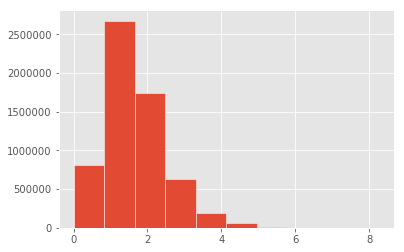

In [29]:
distMatrix = [ [0.0 for i in range(len(vecs))] for j in range(len(vecs))]
dd = cdist(vecs, vecs)
distArray = ssd.squareform(np.asmatrix(dd), checks = False)
# distribution of pairwise distances
plt.hist(distArray, edgecolor="white")
plt.show()

In [32]:
# Find the best hierarchical clustering method
methods = ["ward", "median", "average", "single", "complete"]
bestVal = 0.0
bestMethod = " "
for mm in methods:
    Z = linkage(distArray, method=mm)
    c, cophDist = cophenet(Z, distArray)
    print("[ {0:10s}] Cophenetic = {1:5.2f}".format(mm,c))
    if c > bestVal:
        bestVal = c
        bestMethod = mm
        
#Z = linkage(distArray, method=bestMethod, optimal_ordering=True)
print("Best method is '", mm, "' with best cophenet value = ", bestVal)
Z = linkage(distArray, method=bestMethod)

[ ward      ] Cophenetic =  0.28
[ median    ] Cophenetic =  0.80
[ average   ] Cophenetic =  0.88
[ single    ] Cophenetic =  0.88
[ complete  ] Cophenetic =  0.33
Best method is ' complete 'with best cophenet value =  0.877515662888


Let us now create a picture. We can cut the tree at the desidered level.

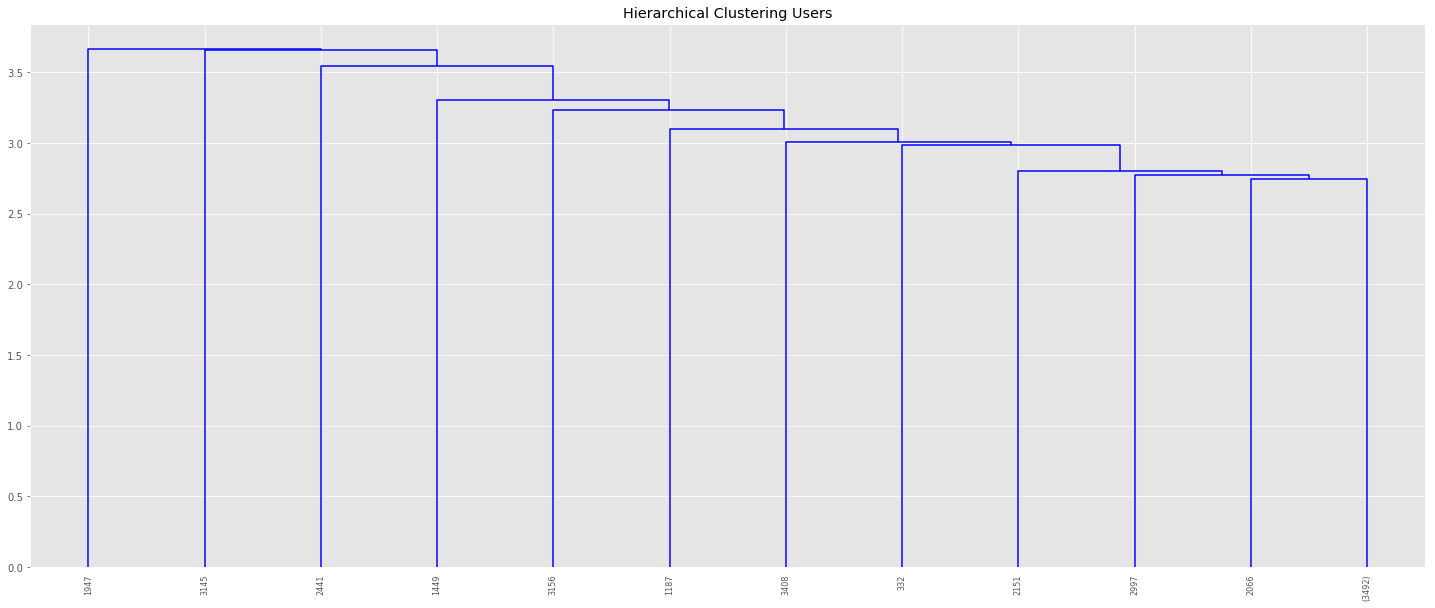

In [36]:
plt.figure(figsize=(25,10))
plt.title("Hierarchical Clustering Users")
pp= dendrogram(
    Z,
    leaf_rotation=90,
    leaf_font_size=8.,
    show_leaf_counts=True,
    get_leaves=True,
    truncate_mode="level",
    p = 10
)
plt.show()

Let us now get the labels associated to each document (i.e., user). Here, we get 508 labels, since each user is assigned to a cluster. Many of them are associated to a cluster of size 1. The variable `maxD` determines how the clusters are cut, i.e., at which depth of the tree we cut the clusters. 

In [45]:
maxD = 1.4 # increase maxD to reduce depth.Therefore, the number of clusters created gets reduced
labels = fcluster(Z, maxD, criterion="distance")
labels = labels - [1]*len(labels)
print("Length labels vs idOriginal vs vecs", len(labels), len(idOriginal), len(vecs))

Length labels vs idOriginal vs vecs 3503 3503 3503


Counter({11: 3244, 10: 2, 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 1, 132: 1, 133: 1, 134: 1, 135: 1, 136: 1, 13

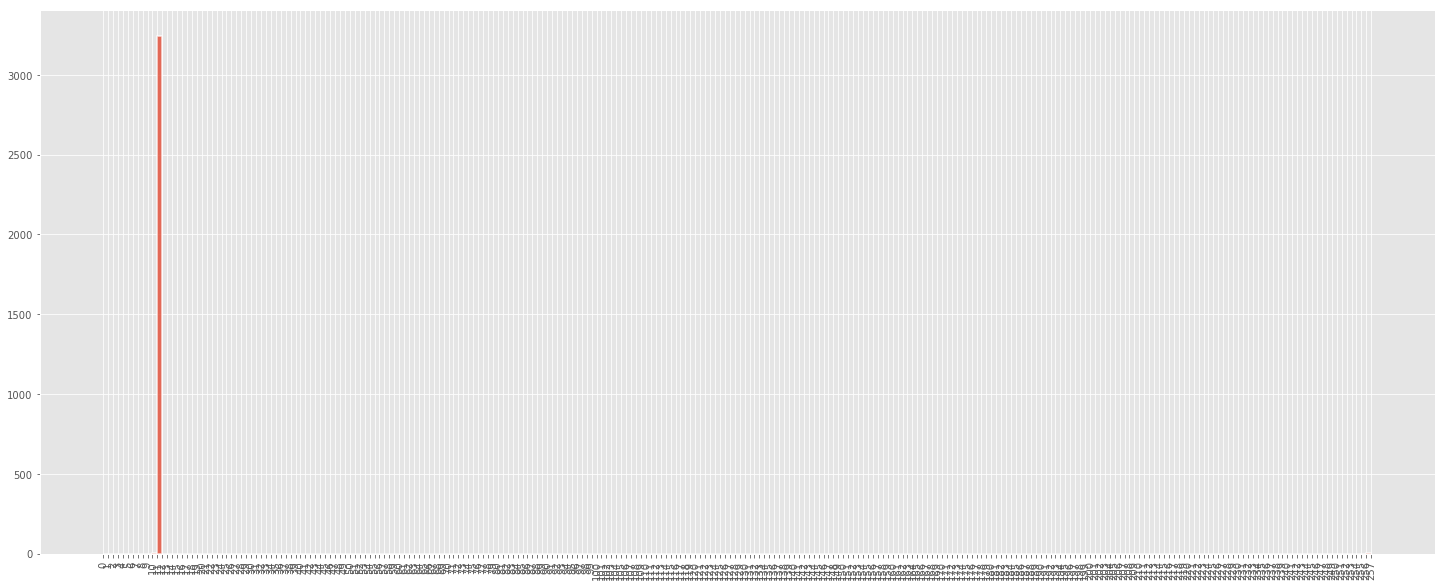

In [46]:
plt.figure(figsize=(25,10))
counter=collections.Counter(labels)
print(counter)
bins = np.arange(min(labels),max(labels))
plt.hist(labels, edgecolor="white", bins=bins, linewidth=1.5, alpha=0.8)
if len(bins) > 25:
    rotation="vertical"
else:
    rotation="horizontal"
plt.xticks(np.round(bins,0), rotation=rotation)
plt.show()

Let us now try to clusterize the most numerous group. In other words, we discard all the users not belonging to the predominant group. We then repeat the clustering approach presented above on the filtered data.

In [47]:
value, count = counter.most_common(1)[0]
print("Cluster {0} is the largest cluster with {1} elements".format(value,count))
vectFiltered = []
idFiltered   = []
for i in range(len(labels)):
    if labels[i] == value:
        vectFiltered.append(vecs[i])
        idFiltered.append(idOriginal[i])
print("Length of vectFiltered is ", len(vectFiltered), "vs idFiltered", len(idFiltered))

Cluster 11 is the largest cluster with 3244 elements
Length of vectFiltered is  3244 vs idFiltered 3244


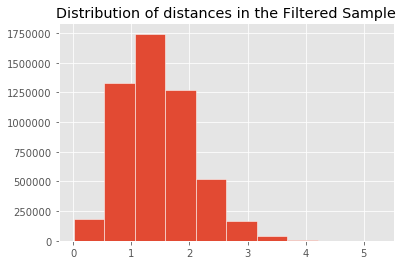

The filtered sample has size 3244 3244


In [48]:
distMatrixF = [ [0.0 for i in range(len(vectFiltered))] for j in range(len(vectFiltered))]
ddF = cdist(vectFiltered, vectFiltered)
distArrayF = ssd.squareform(np.asmatrix(ddF), checks = False)
plt.hist(distArrayF, edgecolor="white")
plt.title("Distribution of distances in the Filtered Sample")
plt.show()
print("The filtered sample has size", len(vectFiltered), len(idFiltered))

In [51]:
methods = ["ward", "median", "average", "single", "complete"]
bestVal = 0.0
bestMethod = " "
for mm in methods:
    ZF = linkage(distArrayF, method=mm)
    c, cophDist = cophenet(ZF, distArrayF)
    print("[ {0:10s}] Cophenetic = {1:5.2f}".format(mm,c))
    if c > bestVal:
        bestVal = c
        bestMethod = mm

print("Best method is '", mm, "' with best cophenet value = ", bestVal)
ZF = linkage(distArrayF, method=bestMethod)

[ ward      ] Cophenetic =  0.29
[ median    ] Cophenetic =  0.72
[ average   ] Cophenetic =  0.80
[ single    ] Cophenetic =  0.80
[ complete  ] Cophenetic =  0.37
Best method is ' complete ' with best cophenet value =  0.802147437815


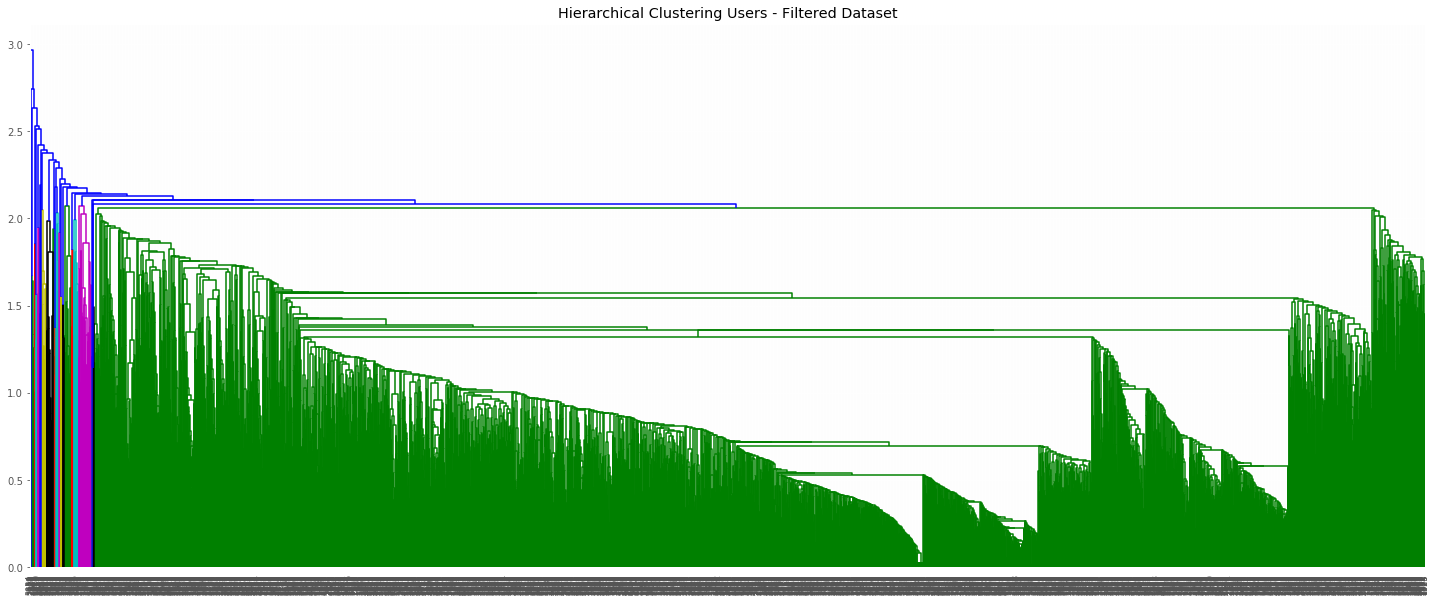

In [52]:
plt.figure(figsize=(25,10))
plt.title("Hierarchical Clustering Users - Filtered Dataset")
pp= dendrogram(
    ZF,
    leaf_rotation=90,
    leaf_font_size=8.,
    show_leaf_counts=True,
    get_leaves=True,
#    truncate_mode="level",
#    p = 10
)
plt.show()

Counter({159: 2329, 166: 131, 125: 26, 165: 26, 147: 25, 131: 23, 86: 22, 72: 18, 134: 17, 105: 16, 62: 14, 145: 13, 117: 12, 144: 12, 163: 12, 19: 11, 130: 11, 37: 9, 161: 9, 55: 8, 115: 8, 141: 8, 164: 8, 12: 7, 139: 7, 149: 7, 154: 7, 157: 7, 0: 6, 89: 6, 127: 6, 135: 6, 150: 6, 158: 6, 184: 6, 213: 6, 113: 5, 129: 5, 153: 5, 7: 4, 31: 4, 35: 4, 53: 4, 59: 4, 63: 4, 64: 4, 69: 4, 87: 4, 120: 4, 146: 4, 155: 4, 198: 4, 219: 4, 249: 4, 5: 3, 21: 3, 23: 3, 41: 3, 46: 3, 49: 3, 77: 3, 101: 3, 102: 3, 108: 3, 116: 3, 128: 3, 133: 3, 136: 3, 137: 3, 140: 3, 143: 3, 156: 3, 162: 3, 180: 3, 195: 3, 248: 3, 255: 3, 257: 3, 3: 2, 14: 2, 18: 2, 20: 2, 24: 2, 25: 2, 29: 2, 33: 2, 36: 2, 38: 2, 40: 2, 42: 2, 44: 2, 45: 2, 51: 2, 54: 2, 57: 2, 58: 2, 60: 2, 61: 2, 67: 2, 68: 2, 71: 2, 79: 2, 80: 2, 81: 2, 85: 2, 88: 2, 92: 2, 95: 2, 97: 2, 98: 2, 99: 2, 103: 2, 107: 2, 110: 2, 111: 2, 112: 2, 114: 2, 122: 2, 123: 2, 124: 2, 132: 2, 138: 2, 151: 2, 152: 2, 181: 2, 193: 2, 196: 2, 200: 2, 209: 2, 2

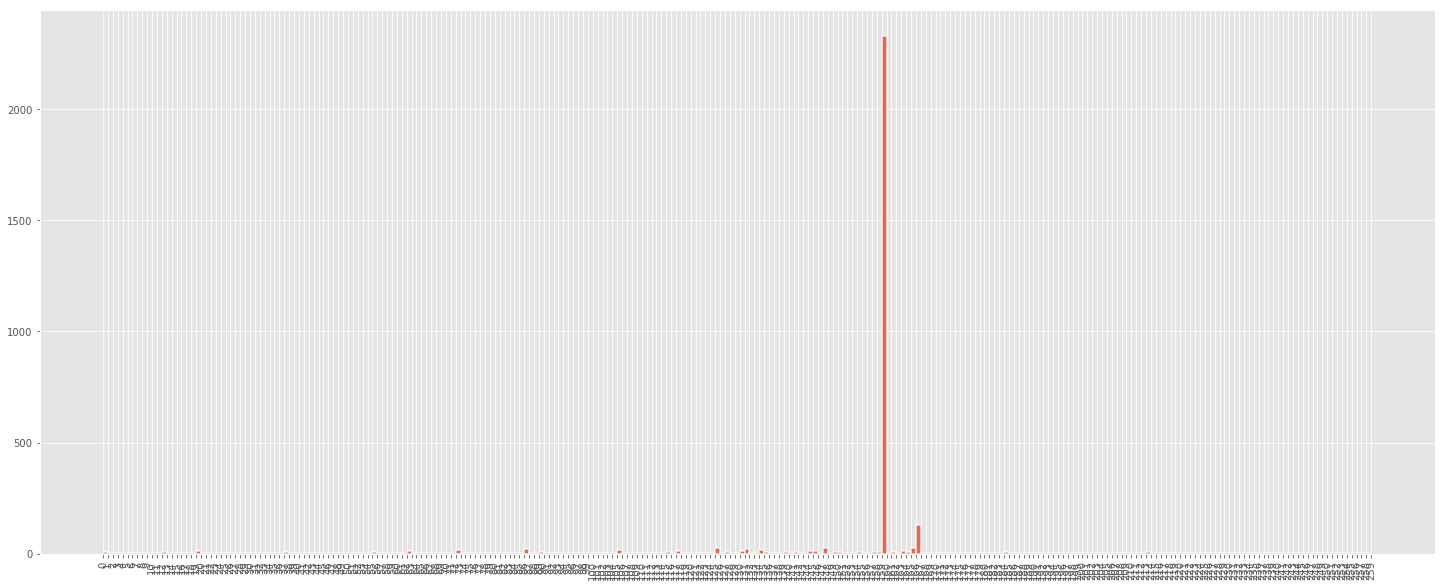

In [55]:
plt.figure(figsize=(25,10))
maxD = 1.5
labelsF = fcluster(ZF, maxD, criterion="distance")
labelsF = labelsF - [1]*len(labelsF)
counter=collections.Counter(labelsF)
print(counter)
bins = np.arange(min(labelsF),max(labelsF))
plt.hist(labelsF, edgecolor="white", bins=bins, linewidth=1.5, alpha=0.8)
if len(bins) > 25:
    rotation="vertical"
else:
    rotation="horizontal"
plt.xticks(np.round(bins,0), rotation=rotation)
plt.show()

In [ ]:
# get most common
for key, val in counter.items():
    print("k and V ", key, val)
print(counter[217])

In [ ]:
for i, f in zip(labelsF, idFiltered):
    if i == 217:
        print("Item ", f, " has cluster 217")

Let us now assign a cluster label to each user. A label equal to -1 assigned to:
* users belonging to the discarded clusters (i.e., those that were filtered out)
* users that belonged to the big initial cluster (kept in the filtering operation) and now belonging to a cluster whose size is below the min cluster size

In [ ]:
min_cluster_size = 4
k = 0
fullLabels = []
for i in idOriginal:
    if idFiltered[k] == i:
        print("item ", i, "found. Its cluster, i.e., ", labelsF[k], "has size ", counter[labelsF[k]])
        if counter[labelsF[k]] >= min_cluster_size:
            fullLabels.append(labelsF[k])            
        else:
            fullLabels.append(-1)
        k += 1
    else:
        fullLabels.append(-1)
print("Length of fullLabels is ", len(fullLabels))   
for i, f in zip(fullLabels, idOriginal):
    print(f, " with label", i)
    

In [ ]:
df = pd.DataFrame({
    "id" : idOriginal,
    "Description" : corpus,
    "Keywords" : docs,
    "labels": labels,
    "filtered": fullLabels
})
print(df.head())
df.to_csv("data/clustersHierarchical.csv")

### Focus on excluding the biggest cluster

Here we do the opposite of what presented above. We first run a cluster analysis on all the users (508). Then, we remove all those belonging to the biggest cluster and repeat the cluster analysis only on the users that were not included in the biggest cluster in the first round.

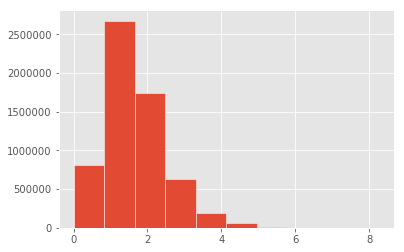

In [88]:
distMatrix = [ [0.0 for i in range(len(vecs))] for j in range(len(vecs))]
dd = cdist(vecs, vecs)
distArray = ssd.squareform(np.asmatrix(dd), checks = False)
# distribution of pairwise distances
plt.hist(distArray, edgecolor="white")
plt.show()

In [89]:
# Find the best hierarchical clustering method
methods = ["ward", "median", "average", "single", "complete"]
bestVal = 0.0
bestMethod = " "
for mm in methods:
    Z = linkage(distArray, method=mm)
    c, cophDist = cophenet(Z, distArray)
    print("[ {0:10s}] Cophenetic = {1:5.2f}".format(mm,c))
    if c > bestVal:
        bestVal = c
        bestMethod = mm

print("Best method is '", mm, "' with best cophenet value = ", bestVal)
Z = linkage(distArray, method=bestMethod)

[ ward      ] Cophenetic =  0.28
[ median    ] Cophenetic =  0.80
[ average   ] Cophenetic =  0.88
[ single    ] Cophenetic =  0.88
[ complete  ] Cophenetic =  0.33
Best method is ' complete ' with best cophenet value =  0.877515662888


In [90]:
maxD = 0.5 # increase maxD to reduce depth.Therefore, the number of clusters created gets reduced
labels = fcluster(Z, maxD, criterion="distance")
labels = labels - [1]*len(labels)
print("Length labels vs idOriginal vs vecs", len(labels), len(idOriginal), len(vecs))

Length labels vs idOriginal vs vecs 3503 3503 3503


Counter({333: 1268, 329: 5, 300: 4, 318: 4, 257: 3, 269: 3, 304: 3, 306: 3, 312: 3, 319: 3, 332: 3, 246: 2, 250: 2, 251: 2, 253: 2, 272: 2, 279: 2, 289: 2, 292: 2, 295: 2, 296: 2, 301: 2, 305: 2, 313: 2, 314: 2, 315: 2, 316: 2, 317: 2, 320: 2, 324: 2, 325: 2, 326: 2, 327: 2, 328: 2, 330: 2, 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 10

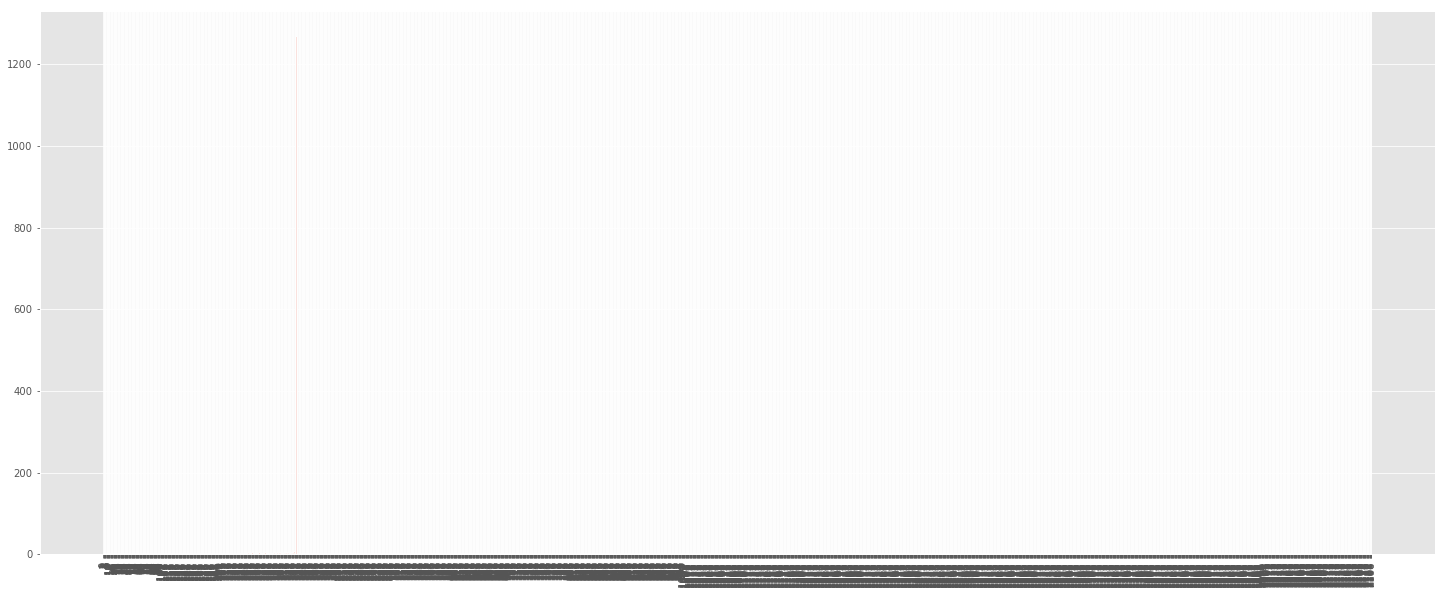

In [91]:
plt.figure(figsize=(25,10))
counter=collections.Counter(labels)
print(counter)
bins = np.arange(min(labels),max(labels))
plt.hist(labels, edgecolor="white", bins=bins, linewidth=1.5, alpha=0.8)
if len(bins) > 25:
    rotation="vertical"
else:
    rotation="horizontal"
plt.xticks(np.round(bins,0), rotation=rotation)
plt.show()

In [92]:
value, count = counter.most_common(1)[0]
print("Cluster {0} is the largest cluster with {1} elements".format(value,count))
vectFiltered = []
idFiltered   = []
idLargest    = []
for i in range(len(labels)):
    if labels[i] != value:
        vectFiltered.append(vecs[i])
        idFiltered.append(idOriginal[i])
    else:
        idLargest.append(idOriginal[i])
print("Length of vectFiltered is ", len(vectFiltered), "vs idFiltered", len(idFiltered))
print("We retain the elements of the largest cluster ", len(idLargest))

Cluster 333 is the largest cluster with 1268 elements
Length of vectFiltered is  2235 vs idFiltered 2235
We retain the elements of the largest cluster  1268


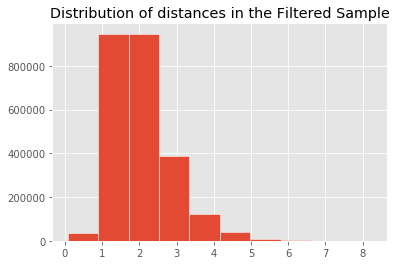

The filtered sample has size 2235 2235


In [93]:
distMatrixF = [ [0.0 for i in range(len(vectFiltered))] for j in range(len(vectFiltered))]
ddF = cdist(vectFiltered, vectFiltered)
distArrayF = ssd.squareform(np.asmatrix(ddF), checks = False)
plt.hist(distArrayF, edgecolor="white")
plt.title("Distribution of distances in the Filtered Sample")
plt.show()
print("The filtered sample has size", len(vectFiltered), len(idFiltered))

In [94]:
methods = ["ward", "median", "average", "single", "complete"]
bestVal = 0.0
bestMethod = " "
for mm in methods:
    ZF = linkage(distArrayF, method=mm)
    c, cophDist = cophenet(ZF, distArrayF)
    print("[ {0:10s}] Cophenetic = {1:5.2f}".format(mm,c))
    if c > bestVal:
        bestVal = c
        bestMethod = mm
        
ZF = linkage(distArrayF, method=bestMethod)

[ ward      ] Cophenetic =  0.41
[ median    ] Cophenetic =  0.28
[ average   ] Cophenetic =  0.83
[ single    ] Cophenetic =  0.80
[ complete  ] Cophenetic =  0.41


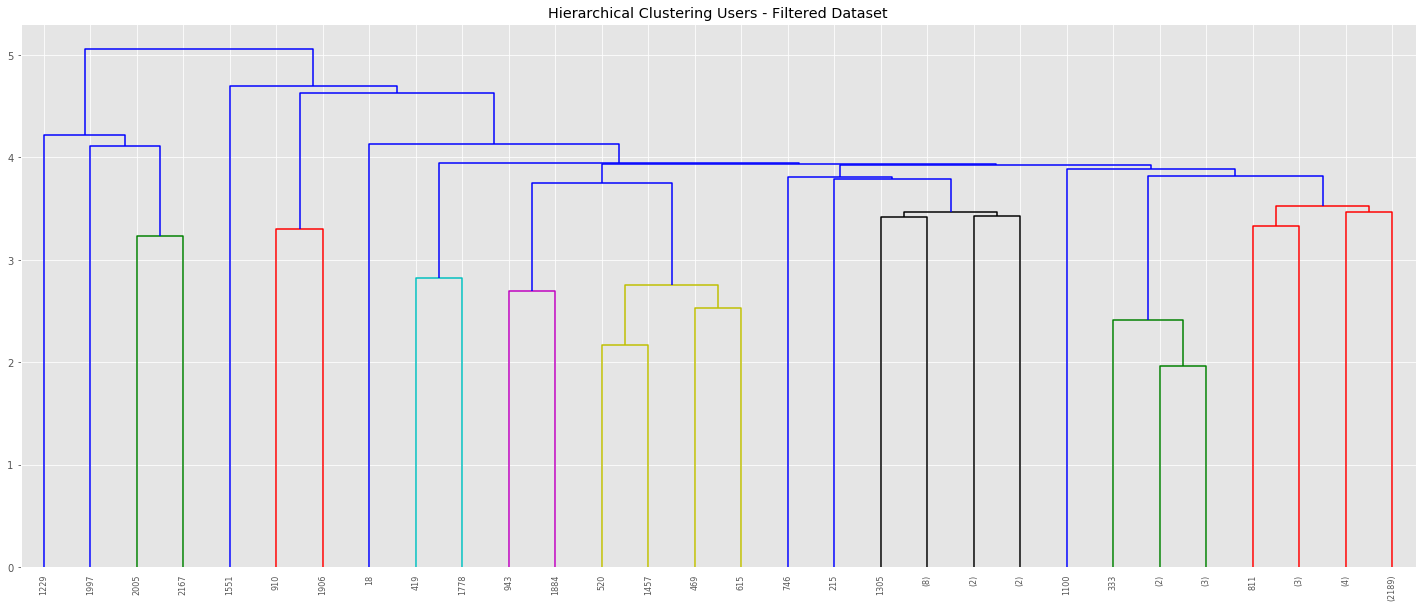

In [95]:
plt.figure(figsize=(25,10))
plt.title("Hierarchical Clustering Users - Filtered Dataset")
pp= dendrogram(
    ZF,
    leaf_rotation=90,
    leaf_font_size=8.,
    show_leaf_counts=True,
    get_leaves=True,
    truncate_mode="level",
    p = 10
)
plt.show()

Counter({701: 622, 260: 143, 695: 36, 642: 22, 697: 22, 667: 20, 582: 19, 266: 16, 590: 15, 474: 14, 618: 14, 678: 12, 689: 12, 569: 11, 687: 11, 158: 10, 510: 10, 663: 10, 693: 10, 232: 9, 538: 9, 694: 9, 500: 8, 604: 8, 630: 8, 634: 8, 200: 7, 220: 7, 530: 7, 537: 7, 557: 7, 614: 7, 656: 7, 675: 7, 681: 7, 691: 7, 475: 6, 492: 6, 544: 6, 573: 6, 602: 6, 651: 6, 673: 6, 699: 6, 159: 5, 179: 5, 217: 5, 229: 5, 414: 5, 491: 5, 600: 5, 610: 5, 625: 5, 631: 5, 647: 5, 670: 5, 68: 4, 127: 4, 186: 4, 235: 4, 250: 4, 256: 4, 369: 4, 503: 4, 546: 4, 566: 4, 633: 4, 654: 4, 660: 4, 674: 4, 682: 4, 685: 4, 686: 4, 692: 4, 698: 4, 700: 4, 715: 4, 171: 3, 172: 3, 252: 3, 254: 3, 259: 3, 264: 3, 269: 3, 412: 3, 426: 3, 459: 3, 471: 3, 476: 3, 486: 3, 501: 3, 504: 3, 523: 3, 553: 3, 581: 3, 586: 3, 609: 3, 622: 3, 624: 3, 626: 3, 640: 3, 650: 3, 655: 3, 677: 3, 683: 3, 684: 3, 92: 2, 100: 2, 118: 2, 119: 2, 122: 2, 126: 2, 144: 2, 150: 2, 157: 2, 177: 2, 178: 2, 180: 2, 185: 2, 211: 2, 215: 2, 223:

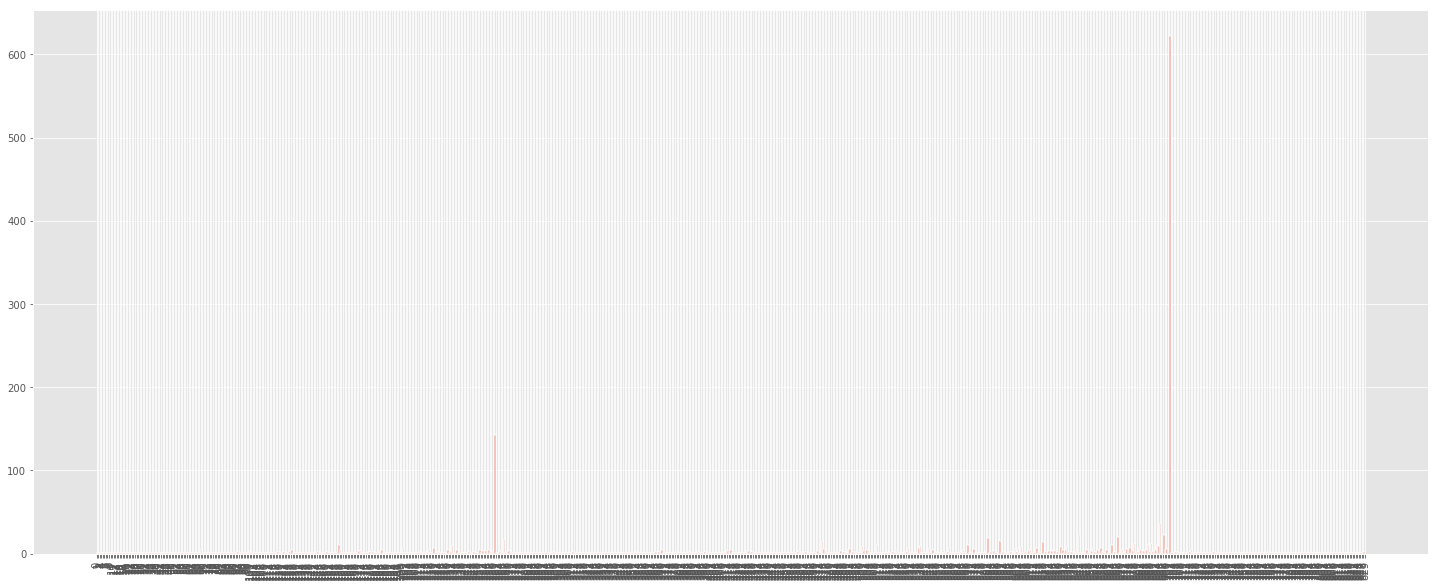

In [96]:
plt.figure(figsize=(25,10))
maxD = 1.2
labelsF = fcluster(ZF, maxD, criterion="distance")
labelsF = labelsF - [1]*len(labelsF)
counter=collections.Counter(labelsF)
print(counter)
bins = np.arange(min(labelsF),max(labelsF))
plt.hist(labelsF, edgecolor="white", bins=bins, linewidth=1.5, alpha=0.8)
if len(bins) > 25:
    rotation="vertical"
else:
    rotation="horizontal"
plt.xticks(np.round(bins,0), rotation=rotation)
plt.show()

In [ ]:
min_cluster_size = 4
k = 0
fullLabels = []
for i in idOriginal:
    if idFiltered[k] == i:
        print("item ", i, "found. Its cluster, i.e., ", labelsF[k], "has size ", counter[labelsF[k]])
        if counter[labelsF[k]] >= min_cluster_size:
            fullLabels.append(labelsF[k])            
        else:
            fullLabels.append(-1)
        if k < len(labelsF)-1:
            k += 1
    elif i in idLargest:
        fullLabels.append(0) # assign to cluster 0 members of largest cluster
    else:
        fullLabels.append(-1)
    print("now k is ", k, "vs len=", len(labelsF), " and full = ", len(fullLabels))
        
print("Length of fullLabels is ", len(fullLabels))   
for i, f in zip(fullLabels, idOriginal):
    print(f, " with label", i)

In [102]:
df = pd.DataFrame({
    "id" : idOriginal,
    "Description" : corpus,
    "Keywords" : docs,
    "labels": labels,
    "filtered": fullLabels
})
print(df.head())
df.to_csv("data/clustersHierarchicalExcludeLargest.csv")

                                         Description  \
0  Jack of all trades, master of none | [SARCASM ...   
1  Professional Trainer,  Business & Life Coach, ...   
2  Sail fast, Live slow. Father. Geek, DIY evange...   
3  Padre. Money manager. Fu BimboAlieno. Economia...   
4  In @ReteDisarmo cercando nonviolenza. Il megli...   

                                            Keywords  filtered  id  labels  
0                     [of, trades, master, of, none]        -1   2      92  
1                     [consultant, are, endorsement]         0   4     333  
2  [fast, slow, evangelist, inside, fan, student,...       701   6     537  
3                       [manager, collaboro, gruppo]       260  11     571  
4  [cercando, nonviolenza, meglio, moglie, figlie...       701  13     880  


Summary: Clusters size

In [108]:
counter=collections.Counter(fullLabels)
print(counter)
pd.DataFrame.from_dict(data=counter, orient='index').to_csv('data/clusters_sizeHierarchical.csv', header=False)

Counter({0: 1268, -1: 885, 701: 622, 260: 143, 695: 36, 642: 22, 697: 22, 667: 20, 582: 19, 266: 16, 590: 15, 474: 14, 618: 14, 678: 12, 689: 12, 687: 11, 569: 11, 663: 10, 158: 10, 693: 10, 510: 10, 538: 9, 694: 9, 232: 9, 604: 8, 500: 8, 630: 8, 634: 8, 656: 7, 530: 7, 537: 7, 675: 7, 220: 7, 557: 7, 691: 7, 200: 7, 614: 7, 681: 7, 544: 6, 673: 6, 699: 6, 573: 6, 651: 6, 602: 6, 475: 6, 492: 6, 491: 5, 179: 5, 647: 5, 670: 5, 414: 5, 159: 5, 600: 5, 217: 5, 610: 5, 229: 5, 625: 5, 631: 5, 256: 4, 654: 4, 685: 4, 660: 4, 674: 4, 369: 4, 682: 4, 686: 4, 692: 4, 698: 4, 700: 4, 250: 4, 68: 4, 566: 4, 503: 4, 546: 4, 186: 4, 235: 4, 633: 4, 715: 4, 127: 4})
